# source: [Ethereum Historical data](https://www.kaggle.com/datasets/themrityunjaypathak/ethereum-historical-data)

### Lib imports 

In [220]:
import pandas as pd 
import re 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler



In [268]:
url = f"https://raw.githubusercontent.com/dsirepos/data/main/ethereum_price.csv"
df = pd.read_csv(url)

In [269]:
# data preview 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 08, 2023","1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,"Mar 07, 2023","1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,"Mar 06, 2023","1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,"Mar 05, 2023","1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,"Mar 04, 2023","1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%


In [270]:
# info about data 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2555 non-null   object
 1   Price     2555 non-null   object
 2   Open      2555 non-null   object
 3   High      2555 non-null   object
 4   Low       2555 non-null   object
 5   Vol.      2555 non-null   object
 6   Change %  2555 non-null   object
dtypes: object(7)
memory usage: 139.9+ KB


## Data Pre-processing 

In [271]:
# column name Fix  : vol. , change %

df.columns= [x.lower().strip().replace(' ', '_') for x in df.columns]

df = df.rename(columns={'vol.' : 'volume', "change_%" : "percentage_change"})
df.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'percentage_change'], dtype='object')

In [272]:
# dype change 

df['date'] = pd.to_datetime(df.date)

df.head()

,date,price,open,high,low,volume,percentage_change
0,2023-03-08,"1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,2023-03-07,"1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,2023-03-06,"1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,2023-03-05,"1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,2023-03-04,"1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%


In [273]:
df['price'] = df['price'].str.replace(',' , '')
df['open'] = df['open'].str.replace(',', '')
df['high'] = df['high'].str.replace(',', '')
df['low'] = df['low'].str.replace(',', '')

df['percentage_change'] = df['percentage_change'].str.replace('%', '')

def normalize_volume(vol):
    if vol[-1] == 'K':
        return float(vol[:-1]) * 1000
    elif vol[-1] == 'M':
        return float(vol[:-1]) * 1_000_000
    elif vol[-1] == 'B':
        return float(vol[:-1]) * 1_000_000_000
    elif vol == '-':
        return np.NaN
    else:
        return float(vol)


df['volume'] = df['volume'].apply(normalize_volume)



df.head()

,date,price,open,high,low,volume,percentage_change
0,2023-03-08,1553.49,1561.79,1569.70,1548.98,498570.0,-0.53
1,2023-03-07,1561.78,1565.84,1580.95,1536.31,460100.0,-0.26
2,2023-03-06,1565.84,1564.36,1581.13,1555.43,322160.0,0.09
3,2023-03-05,1564.37,1566.73,1587.95,1556.84,313010.0,-0.15
4,2023-03-04,1566.73,1569.45,1577.02,1550.10,247020.0,-0.14


In [274]:
_ = df.isna().sum()
_.head()

date     0
price    0
open     0
high     0
low      0
dtype: int64

## Missing data

In [276]:
_ = df.query('volume.isnull()')
_.head()

,date,price,open,high,low,volume,percentage_change
1928,2017-11-26,464.00,464.00,464.00,464.00,NaN,0.00
2402,2016-08-09,10.16,10.16,10.16,10.16,NaN,0.00
2403,2016-08-08,10.16,10.16,10.16,10.16,NaN,0.00
2404,2016-08-07,10.16,10.16,10.16,10.16,NaN,0.00
2405,2016-08-06,10.16,10.16,10.16,10.16,NaN,0.00


In [277]:
# imputing with interpolated data ( makes assumptions based on the neighbouring non null values ).

df['volume'] = df['volume'].interpolate(method='linear')


In [278]:
# set date as index 

df = df.sort_values(by=['date'])
df = df.set_index('date')



### Normalize scale 

In [279]:
# convert numerical to float types

df = [df[col].astype(float) for col in df.columns]
df = pd.DataFrame(df).T


# normalize volume column , + 1 to avoid zero log or negative log values. 

df['volume_log'] = np.log(df['volume'] + 1)
df = df.drop(columns=['volume'])
df.head()

,price,open,high,low,percentage_change,volume_log
date,,,,,,
2016-03-10,11.75,11.20,11.85,11.07,4.91,0.000000
2016-03-11,11.95,11.75,11.95,11.75,1.70,5.198497
2016-03-12,12.92,11.95,13.45,11.95,8.12,6.722630
2016-03-13,15.07,12.92,15.07,12.92,16.64,7.170888
2016-03-14,12.50,15.07,15.07,11.40,-17.05,11.431509


## Feature Extraction 

### Simple Moving Average

In [282]:
## sampling a subset , for calculating  moving average 

df_open = df['2016-01': '2016-03'][['open']]

df_open.head(3)

,open
date,
2016-03-10,11.20
2016-03-11,11.75
2016-03-12,11.95


In [284]:
df_open['open_sma'] = df_open['open'].rolling(window=3).mean()
df_open.head()

,open,open_sma
date,,
2016-03-10,11.20,NaN
2016-03-11,11.75,NaN
2016-03-12,11.95,11.633333
2016-03-13,12.92,12.206667
2016-03-14,15.07,13.313333


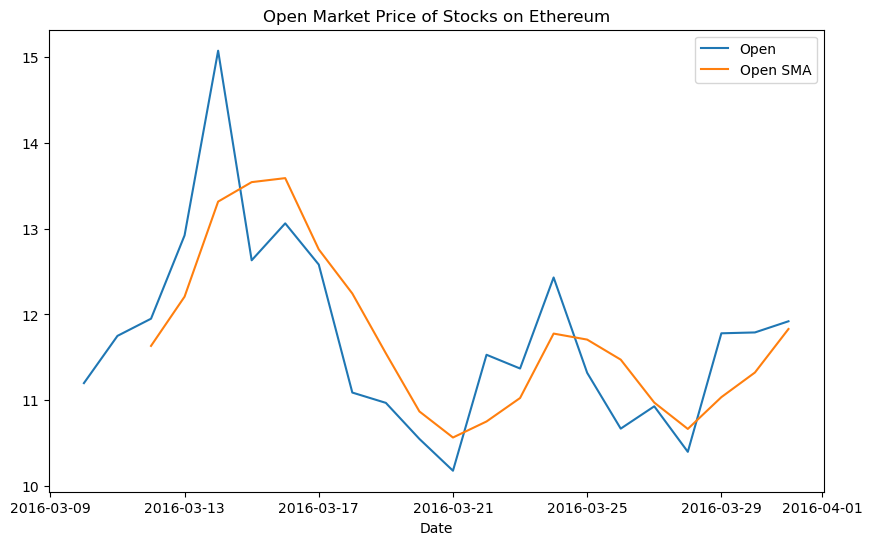

In [285]:
# line distribution: Viewing trends of the open market price of the stocks on Ethereum
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'open' and 'open_sma' columns on the same axis
ax.plot(df_open.index, df_open['open'], label='Open')
ax.plot(df_open.index, df_open['open_sma'], label='Open SMA')

# Set plot title, x-axis label, and legend
ax.set_title('Open Market Price of Stocks on Ethereum')
ax.set_xlabel('Date')
ax.legend()

# Show the plot
plt.show()





### weighted Moving Average

In [287]:
# weighted moving average

def wma(weights):
    def calc(x):
        return (weights*x).mean()
    return calc

df_open['open_wma'] = df_open['open'].rolling(window=3).apply(wma(np.array([0.5, 1, 1.5]))).shift(1)


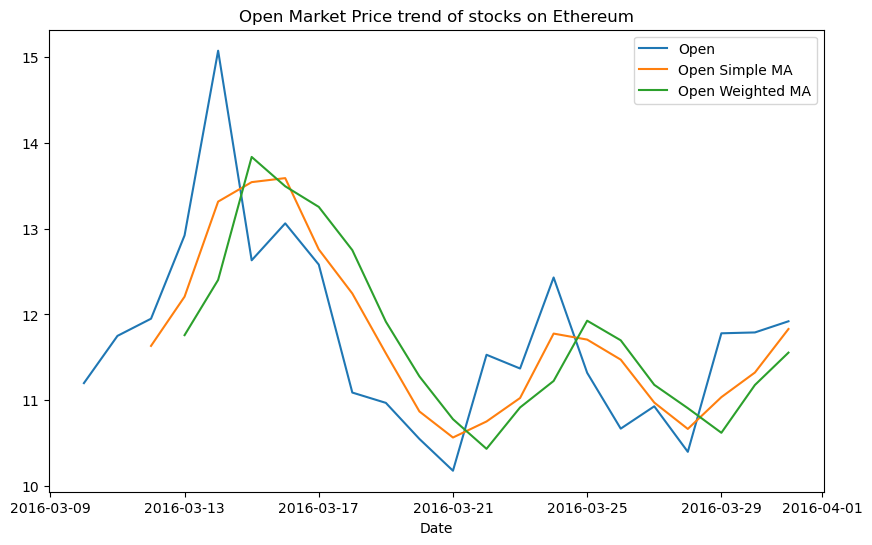

In [290]:
# Line Distirbution of Trends in Stock price on Etherum

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'open' and 'open_sma' columns on the same axis
ax.plot(df_open.index, df_open['open'], label='Open')
ax.plot(df_open.index, df_open['open_sma'], label='Open Simple MA')

ax.plot(df_open.index, df_open['open_wma'], label='Open Weighted MA')

# Set plot title, x-axis label, and legend
ax.set_title('Open Market Price trend of stocks on Ethereum')
ax.set_xlabel('Date')
ax.legend()

# Show the plot
plt.show()


### Exponential moving average 

In [291]:

df_open['open_ema'] = df_open['open'].ewm(alpha=0.7, adjust=False, min_periods=3).mean().shift(1)


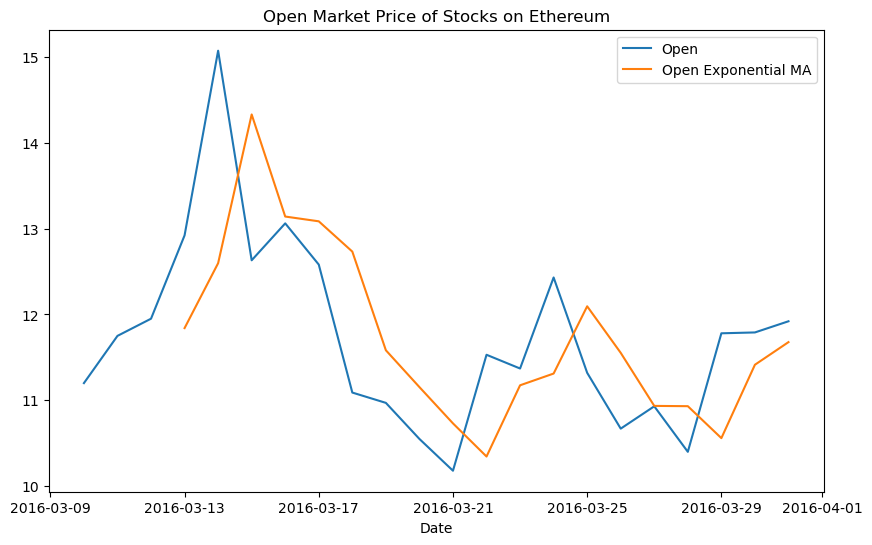

In [293]:
# line distribution 
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'open' and 'open_sma' columns on the same axis
ax.plot(df_open.index, df_open['open'], label='Open')
# ax.plot(df_open.index, df_open['open_sma'], label='Open SMA')


# ax.plot(df_open.index, df_open['open_wma'], label='Open WMA')
ax.plot(df_open.index, df_open['open_ema'], label='Open Exponential MA')
# Set plot title, x-axis label, and legend
ax.set_title('Open Market Price of Stocks on Ethereum')
ax.set_xlabel('Date')
ax.legend()

# Show the plot
plt.show()


### Observations On Moving Averages : 
1. exponential moving average, seems to be suitable ,as the changes in the opening price is frequent, hence the exponetial moving average is best suited as it considered these drastic shifts in preditcor values.

### define a utility function: Feature Extractor 

In [295]:
def feature_extractor(df, predictors, alpha=0.7):
    for column in predictors:
        df[column+"_ema"] = df[column].ewm(alpha=alpha, adjust=False, min_periods=3).mean().shift(1)
    return df

## Feature Extraction Results 

In [296]:
target = 'percentage_change'
predictors = list(df.columns)

predictors.remove(target)


df  = feature_extractor(df, predictors=predictors)

df.head()

,price,open,high,low,percentage_change,volume_log,price_ema,open_ema,high_ema,low_ema,volume_log_ema
date,,,,,,,,,,,
2016-03-10,11.75,11.20,11.85,11.07,4.91,0.000000,NaN,NaN,NaN,NaN,NaN
2016-03-11,11.95,11.75,11.95,11.75,1.70,5.198497,NaN,NaN,NaN,NaN,NaN
2016-03-12,12.92,11.95,13.45,11.95,8.12,6.722630,NaN,NaN,NaN,NaN,NaN
2016-03-13,15.07,12.92,15.07,12.92,16.64,7.170888,12.6110,11.84050,12.9910,11.82880,5.797525
2016-03-14,12.50,15.07,15.07,11.40,-17.05,11.431509,14.3323,12.59615,14.4463,12.59264,6.758880


## Train, Test split for Predictive Analysis

In [297]:
# train , test split 

X = df[predictors]
y = df[target]

# Perform time-based train-test split
train_size = int(len(df) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Save pre-processed Data

In [298]:
X_train.to_parquet('X_train_ethereum.parquet', index=False)
df.to_parquet('X_test_ethereum.parquet', index=False)
df.to_parquet('y_train_ethereum.parquet', index=False)
df.to_parquet('y_train_ethereum.parquet', index=False)